In [1]:
import pandas as pd
import numpy as np
import datetime
import sklearn
from sklearn.model_selection import TimeSeriesSplit

from collections import Counter
from sklearn.base import BaseEstimator
from tqdm import trange
from imblearn.combine import SMOTETomek
from sklearn.linear_model import LogisticRegression
import copy

from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import make_pipeline, Pipeline
from imblearn.under_sampling import     OneSidedSelection 
from xgboost import XGBClassifier
from imblearn.under_sampling import ClusterCentroids 
from sklearn.preprocessing import StandardScaler

In [2]:
def train_val_ts_split(X, th=0.7, split_target=None): # X - датафрейм, в котором есть  TS_indexer
    unique_TS_split = np.array(sorted(X.TS_indexer.unique()))
    batchsize = int(len(unique_TS_split)*th)
    excerpt_train = np.arange(0, batchsize)
    excerpt_val =  np.arange(batchsize, len(unique_TS_split))
    d_train =  X[X.TS_indexer.isin(unique_TS_split[excerpt_train])]
    d_val = X[X.TS_indexer.isin(unique_TS_split[excerpt_val])]
    if split_target is None:
        return d_train, d_val
    else:
        return d_train.drop('label', axis=1), d_train.label, d_val.drop('label', axis=1), d_val.label

### Подготовка данных

Загружаем данные с фичами.

In [4]:
data = pd.read_feather("../data/combined_dataset/train_v1.fth")

data['TS_indexer'] = data.short_date
data.fillna(0, inplace=True)
data.drop(['event_id', 'event_time'], axis = 1, inplace=True)

data = data[data.label>=0]

Разбиваем на трейн и валидацию.

In [5]:
X_train, X_val = train_val_ts_split(data , th=0.7, split_target=None)
y_val = X_val['label'].values
y_train = X_train['label']#.values
x_train = X_train.drop(['label', 'short_date','TS_indexer', 'user_id'], axis=1)

Трейн разбиваем на фолды для временной кросс-валидации.

In [6]:
unique_TS_split_train = np.array(sorted(X_train.TS_indexer.unique()))

In [7]:
tscv = TimeSeriesSplit(n_splits=3, max_train_size=21)

In [8]:
for train_index, test_index in tscv.split(unique_TS_split_train):
    print("TRAIN LEN:", len(unique_TS_split_train[train_index]), "TEST LEN:", len(unique_TS_split_train[test_index]))

TRAIN LEN: 6 TEST LEN: 5
TRAIN LEN: 11 TEST LEN: 5
TRAIN LEN: 16 TEST LEN: 5


Делаем разбиение для кросс-валидации.

In [9]:
X_train_id = X_train.reset_index(drop=True)

temp_TS_cv = [
    (X_train_id[X_train_id.TS_indexer.isin(unique_TS_split_train[train_index])].index.tolist(), 
     X_train_id[X_train_id.TS_indexer.isin(unique_TS_split_train[test_index])].index.tolist()) for (train_index, test_index) in tscv.split(unique_TS_split_train) if len(train_index)>=2]

completed_TS_cv = [(train, test) for (train, test) in temp_TS_cv if X_train_id.iloc[test].label.sum() >= 1]

In [10]:
len(completed_TS_cv)

3

In [11]:
for i in range(len(completed_TS_cv)):
    print("Train period: " + str(X_train_id.loc[completed_TS_cv[i][0]].short_date.min())+' - '+str(X_train_id.loc[completed_TS_cv[i][0]].short_date.max()))
    print("Test period: " + str(X_train_id.loc[completed_TS_cv[i][1]].short_date.min())+' - '+str(X_train_id.loc[completed_TS_cv[i][1]].short_date.max()))
    print("\r\n")

Train period: 20171029 - 20171103
Test period: 20171104 - 20171108


Train period: 20171029 - 20171108
Test period: 20171109 - 20171113


Train period: 20171029 - 20171113
Test period: 20171114 - 20171118




In [12]:
X = X_train_id.drop(['user_id' ,'short_date','TS_indexer', 'label'], axis=1).as_matrix()

In [13]:
y_train = y_train.values

### GridSearchCV

Будем искать вокруг значений из ноутбука с заданием.
Порядок поиска:
* Первоначальное приближение learning_rate
* Оптимальный learning_rate около предыдущего лучшего
* max_depth около текущего оптимального
* n_estimators около текущего оптимального

In [16]:
print('Model with grid search')
# 
params={
'learning_rate' : np.logspace(np.log(0.01), np.log(0.9), 5)
}

xgb = XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.5,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=200,
       objective='binary:logistic', reg_alpha=8, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.6, n_jobs=-1)

rs = GridSearchCV(xgb,
                  params,
                  cv=completed_TS_cv,
                  scoring="neg_log_loss",
                  verbose=2)

Model with grid search


In [19]:
print('Model with grid search')
# 
params={
'learning_rate' : np.linspace(0.05, 0.2, 5)
}

xgb = XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.5,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=200, nthread=-1,
       objective='binary:logistic', reg_alpha=8, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.6, n_jobs=16)
rs = GridSearchCV(xgb,
                  params,
                  cv=completed_TS_cv,
                  scoring="neg_log_loss",
                  verbose=2)

Model with grid search


In [24]:
print('Model with grid search')
# 
params={
'max_depth' : [ 3, 5, 6, 7, 8]
}
xgb = XGBClassifier(n_jobs=-1,learning_rate=0.32222, n_estimators=200)
rs = GridSearchCV(xgb,
                  params,
                  cv=completed_TS_cv,
                  scoring="neg_log_loss",
                  n_jobs=1,
                  verbose=2)

Model with grid search


In [182]:
print('Model with grid search')
# 
params={
'n_estimators' : [100, 150, 200, 250, 300]
}
xgb = XGBClassifier(n_jobs=-1,learning_rate=0.32)
rs = GridSearchCV(xgb,
                  params,
                  cv=completed_TS_cv,
                  scoring="neg_log_loss",
                  n_jobs=1,
                  verbose=2)

Model with grid search


In [201]:
print('Model with grid search')
# 
params={
'reg_alpha' : np.logspace(np.log(0.001), np.log(2), 10)
}
xgb = XGBClassifier(n_jobs=-1,learning_rate=0.32222, n_estimators=200)
rs = GridSearchCV(xgb,
                  params,
                  cv=completed_TS_cv,
                  scoring="neg_log_loss",
                  n_jobs=1,
                  verbose=2)

Model with grid search


In [205]:
print('Model with grid search')
# 
params={
'reg_alpha' : np.linspace(4, 10, 10)
}
xgb = XGBClassifier(n_jobs=-1,learning_rate=0.32222, n_estimators=200)
rs = GridSearchCV(xgb,
                  params,
                  cv=completed_TS_cv,
                  scoring="neg_log_loss",
                  n_jobs=1,
                  verbose=2)

Model with grid search


In [20]:
rs.fit(X, y_train)
rs.best_params_, rs.best_score_

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] learning_rate=0.05 ..............................................
[CV] ............................... learning_rate=0.05, total= 1.2min
[CV] learning_rate=0.05 ..............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s


[CV] ............................... learning_rate=0.05, total= 2.1min
[CV] learning_rate=0.05 ..............................................
[CV] ............................... learning_rate=0.05, total= 3.2min
[CV] learning_rate=0.08750000000000001 ...............................
[CV] ................ learning_rate=0.08750000000000001, total= 1.2min
[CV] learning_rate=0.08750000000000001 ...............................
[CV] ................ learning_rate=0.08750000000000001, total= 2.2min
[CV] learning_rate=0.08750000000000001 ...............................
[CV] ................ learning_rate=0.08750000000000001, total= 3.8min
[CV] learning_rate=0.125 .............................................
[CV] .............................. learning_rate=0.125, total= 1.2min
[CV] learning_rate=0.125 .............................................
[CV] .............................. learning_rate=0.125, total= 2.3min
[CV] learning_rate=0.125 .............................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 51.2min finished


({'learning_rate': 0.08750000000000001}, -0.013116185204664198)

In [207]:
xgb = XGBClassifier(n_jobs=-1, learning_rate=0.322222, n_estimators=200, max_depth=3, reg_alpha=8.0)

xgb.fit(X ,y_train)
preds_proba = xgb.predict_proba(X_val.drop(['label', 'short_date','TS_indexer', 'user_id'], axis=1).values
                             )
preds = xgb.predict(X_val.drop(['label', 'short_date','TS_indexer', 'user_id'], axis=1).values
                 )

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [21]:
xgb = XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.5,
       gamma=0, learning_rate=0.0875, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=200,
       objective='binary:logistic', reg_alpha=8, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.6, n_jobs=-1)
xgb.fit(X ,y_train)

preds_proba = xgb.predict_proba(X_val.drop(['label', 'short_date','TS_indexer', 'user_id'], axis=1).values
                             )
preds = xgb.predict(X_val.drop(['label', 'short_date','TS_indexer', 'user_id'], axis=1).values
                 )

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


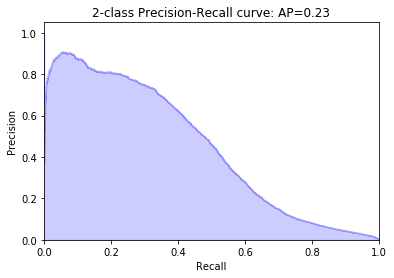

0.4469886696215203

In [22]:
average_precision = average_precision_score(y_val, preds)
precision, recall, thresholds = precision_recall_curve(y_val, preds_proba[:, 1])

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
plt.show()

metrics.auc(recall, precision)